<a href="https://colab.research.google.com/github/AnnaNKorotkova/Data/blob/master/seminar_2_ab_design_elisova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар № 2
# Дизайн аб-теста на реальном датасете

Импорты библиотек

In [ ]:
import sys
!{sys.executable} -m pip install mmh3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 1.3 MB/s eta 0:00:00


In [ ]:
import os
import datetime
import requests
import base64

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tqdm.auto import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import mmh3
import warnings
warnings.simplefilter('ignore')

# Датасет для экспериментов

1. Скачиваем датасет

In [ ]:
# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

Распаковываем архив из 3 файлов

In [ ]:
!unzip data_kion.zip

Archive:  data_kion.zip
replace __MACOSX/._data_kion? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 📺 Данные: датасет КИОН
- **просмотры** фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [ ]:
interactions = pd.read_csv('data_kion/interactions_df.csv')

users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

Мы будем использовать данные `interactions` = пользователь `user_id` посмотрел фильм `item_id` столько-то секунд `total_dur` в такую дату `last_watch_dt`
- с датой last_watch_dt
- длительностью просмотра total_dur
- % просмотра watched_pct

In [ ]:
interactions.head(5).append(interactions.tail())

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [ ]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


# Вариант дизайна 1

Так как в данных есть недельная сезонность, то длину теста меньше 1 недели не будем рассматривать

1) Оценим сколько у нас пользователей за 1 неделю

In [ ]:
max_date = interactions['last_watch_dt'].max()

In [ ]:
interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]['user_id'].nunique()

185907

In [ ]:
# выделим данные за одну (последнюю) неделю
week1 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]

In [ ]:
week1 = week1.groupby('user_id', as_index=False).agg({'total_dur': sum})

In [ ]:
week1.head()

,user_id,total_dur
0,1,1593
1,1000001,52
2,1000003,625
3,1000008,3691
4,1000009,2444


## Выбор метрики

- хотим использовать метрику "spend" = длину просмотра на пользователя (total_dur в датасете) - так как это основная метрика, на которую смотрит бизнес

- То есть хотим, чтобы в тесте в группе B средняя длина просмотра на пользователя увеличилась

# Выбор эффекта

Пусть на первом этапе решили, что интересует эффект = 5% как разница между группами

### Посмотрим на распределение метрики

(помним: дисперсия должна быть невысокая)

<Axes: >

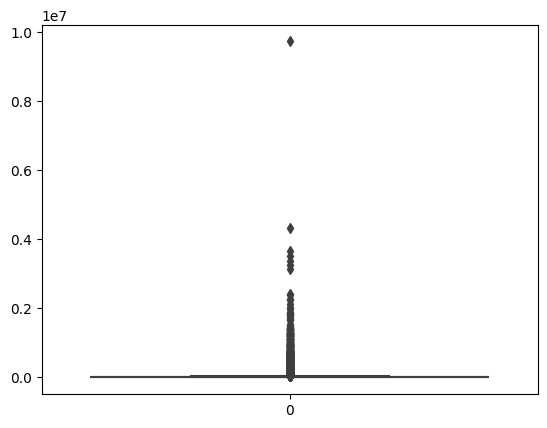

In [ ]:
import seaborn as sns

sns.boxplot(week1['total_dur'].values)

In [ ]:
# кажется у нас есть выброс - это плохо, удалим его
week1['total_dur'].max()

9731801

In [ ]:
week1['total_dur'].std()

62639.864877425716

In [ ]:
week1[week1['total_dur'] == week1['total_dur'].max()]

,user_id,total_dur
128751,696597,9731801


In [ ]:
print(week1.shape)
week1 = week1[(week1['total_dur'] < week1['total_dur'].std() * 3)]
print(week1.shape)

(185907, 2)
(183790, 2)


Данные не похожи на нормальное распределение: большинство людей смотрят понемногу, распределение не симметричное.

Что это значит? Что самые популярные критерии (t-test, z-test) для нашей метрики "длина просмотра" не подойдут, так как они требуют условия на нормальность распределения

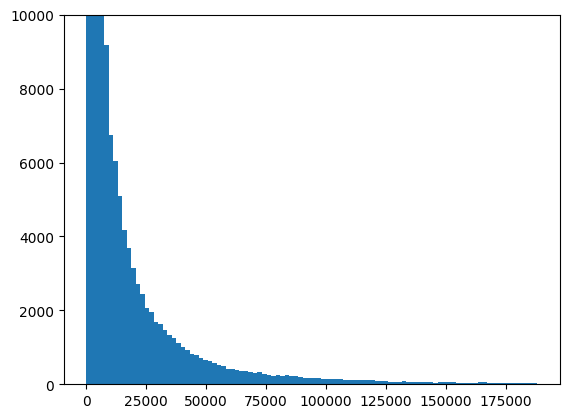

In [ ]:
week1['total_dur'].hist(bins=100)
plt.ylim([0, 10000])
plt.grid(False)

## Выбор критерия

А что если использовать критерий Манна-Уитни?

- Нормальность данных не требуется
- Для него нужен ряд неповторяющихся уникальных значений (например: [23, 456, ... 67, 20])

## Алгоритм подбора похожих групп

- Используем хэш функцию для этого. Посчитаем хэш от айди, найдем остаток от деления на 2 (так как 2 группы) и по остатку определим к какой группе относитсч пользователь. То есть по айди пользователя она разобьет всех пользователей на 2 группы.

### Умеем генерировать "соль"

случайную строку, добавляемую к айдишникам при разбивке на группы по хэшу.

- В качестве неслучайного значения можно использовать номер задачи в Jira или дату.


- Не забудьте логировать значения соли ваших экспериментов!

In [ ]:
def salt_generator():
  salt = os.urandom(8)
  return base64.b64encode(salt).decode('ascii')


def get_salt(user_salt=None, save_salt=True):

  # соль задает пользователь или генерируем
  if user_salt:
      salt = user_salt
  else:
      salt = salt_generator()

  # логируем соль
  if save_salt:
      today = datetime.today().date().strftime('%Y-%m-%d')
      with open(f"salt_{today}.txt", 'w') as f:
          f.write(salt)
  return salt


# попробуйте запустить несколько раз и посмотрите на результат
salt_generator()

'6tTlnw5HZLU='

### Функция для разделения по хэшу (простой вариант)


**Что такое хэш-функция?**

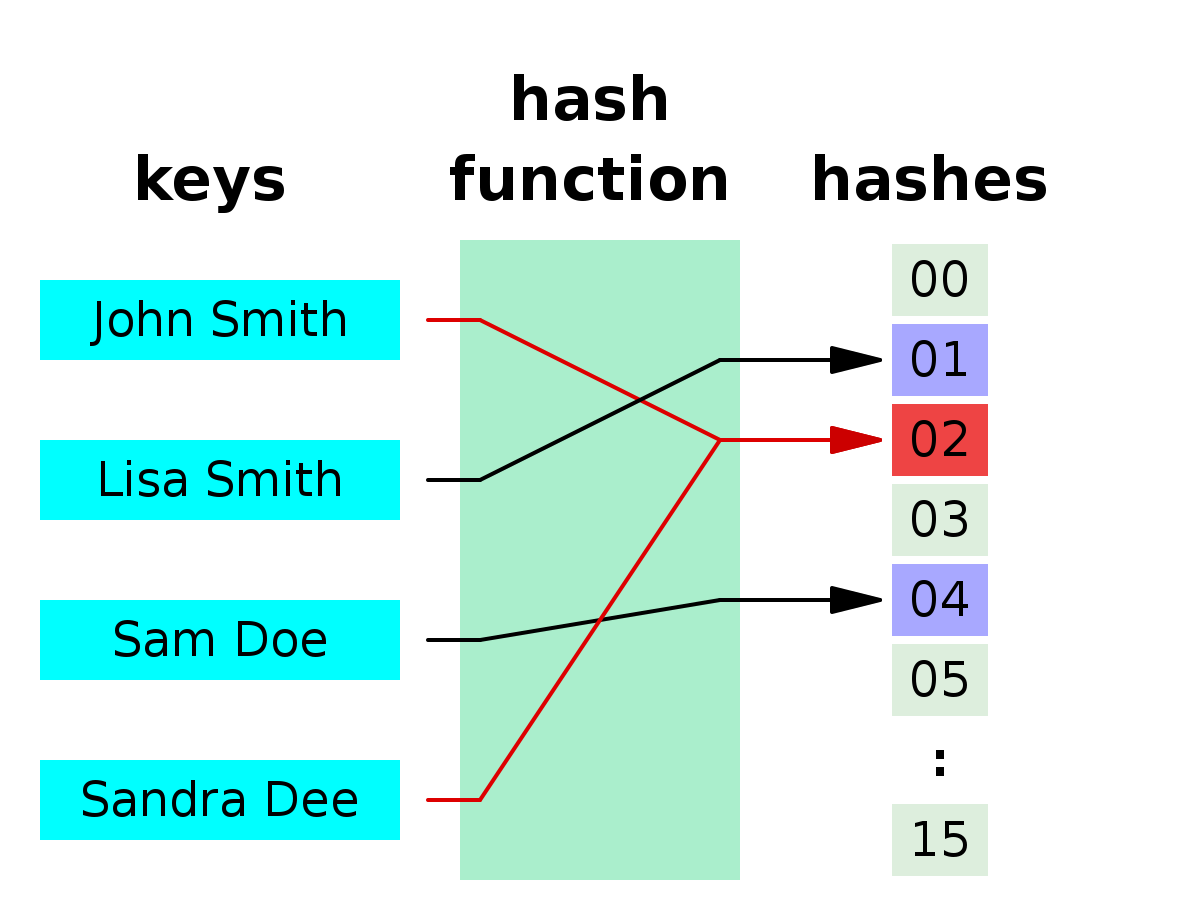

Это функция, которая получает на вход строку любой длины, математически обрабатывает ее и вовзращает всегда последовательность одной и той же длины.

- есть разные алгоритмы: MD5, MurMurHash, SHA256
- обратно расшифровать нельзя (односторонняя)
- равномерно распределяет входящие айдишники, что позволяет по % от деления на кол-во групп разделить их на группы


In [ ]:
def get_hash(df, col='user_id', save_salt=True):

    salt = salt_generator()

    # разбиваем id на 2 группы с использванием ф-ии хэширования mmh3 murmurhash
    dfh = df.copy()
    dfh['hash'] = dfh[col].apply(lambda x: mmh3.hash128(x + salt))
    dfh['group'] = dfh['hash'] % 2
    return dfh

Метрику + критерий + как разбивать на группы - выбрали




## Переходим к валидации критерия
- оценка распределения p_value
- оценка мощности
- корректности

**Распределения p_value** при корректном подборе пары метрика + критерий -  равномерное распределение

**Достоверность (Корректность)** - вероятность того, что найдет различие, когда его нет

$$significance = Pr(\text{reject }H_0 | H_0 \text{ is true})$$

**Мощность** - вероятность того, что критерий найдет различие в случае, когда оно есть

$$power = Pr(\text{reject }H_0 | H_1 \text{ is true})$$

Увеличение мощности криетрия ведет к уменьшению вероятности ошибки второго рода

In [ ]:
# делим пользователей на группы A и B по хэшу с использованием соли
week1 = get_hash(week1)
week1.head()

,user_id,total_dur,hash,group
0,1,1593,31616602593376858590961068176264110605,1
1,1000001,52,4559215917150515933503236474588028524,0
2,1000003,625,103325062362555221559996585816529275466,0
3,1000008,3691,75238598715006157485566931737896594252,0
4,1000009,2444,7746817183065912724161281734650133015,1


In [ ]:
from scipy.stats import mannwhitneyu

# проверим, как работает код критерия
u, p = mannwhitneyu(week1[week1['group'] == 0]['total_dur'].values,
                    week1[week1['group'] == 1]['total_dur'].values)

print(f"Значение статистики = {u}, p_value = {p}")

Значение статистики = 4228063328.5, p_value = 0.6122532410175612


Проверка распределения p_value - должно быть равномерное

In [ ]:
pvalues = []

for i in tqdm(range(100)):  # 1000

  week1_hash = get_hash(week1, save_salt=False)

  u, p = mannwhitneyu(
        week1_hash[week1_hash['group'] == 0]['total_dur'].values,
        week1_hash[week1_hash['group'] == 1]['total_dur'].values
    )
  pvalues.append(p)

  0%|          | 0/100 [00:00<?, ?it/s]

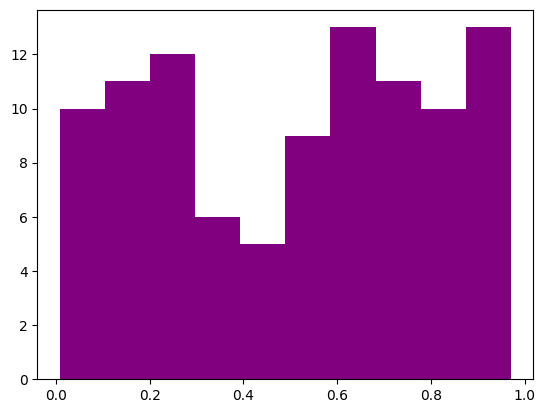

In [ ]:
plt.hist(pvalues, bins=10, color='purple');

Ой. Кажется критерий Манна-Уитни не подходит. А почему так произошло?

In [ ]:
for i in tqdm(range(10)):

  week1_hash = get_hash(week1, save_salt=False)

  group_a = week1_hash[week1_hash['group'] == 0]
  group_b = week1_hash[week1_hash['group'] == 1]

  print(f"% уник. значений группы А = {round(group_a['total_dur'].nunique() / group_a.shape[0] * 100, 2)}")
  print(f"% уник. значений группы B = {round(group_b['total_dur'].nunique() / group_b.shape[0] * 100, 2)}")
  print('')


  0%|          | 0/10 [00:00<?, ?it/s]

% уник. значений группы А = 34.39
% уник. значений группы B = 34.51

% уник. значений группы А = 34.34
% уник. значений группы B = 34.53

% уник. значений группы А = 34.36
% уник. значений группы B = 34.51

% уник. значений группы А = 34.46
% уник. значений группы B = 34.37

% уник. значений группы А = 34.39
% уник. значений группы B = 34.51

% уник. значений группы А = 34.37
% уник. значений группы B = 34.41

% уник. значений группы А = 34.6
% уник. значений группы B = 34.37

% уник. значений группы А = 34.33
% уник. значений группы B = 34.53

% уник. значений группы А = 34.47
% уник. значений группы B = 34.32

% уник. значений группы А = 34.49
% уник. значений группы B = 34.43



Кажется мы все-таки нарушили область применимости критерия - значения длины просмотра на пользователя не настолько уникальны, как нам показалось сначала. Что ж - это реальные данные.

Но так как мы следовали четко по алгоритму дизайна, ошибку удалось обнаружить достаточно рано.


# Вариант дизайна 2



## Выбор метрики: длина просмотра на пользователя

- оставляем метрику "spend" = длину просмотра на пользователя (total_dur в датасете)

- хотим, чтобы в тесте в группе B средняя длина просмотра на пользователя увеличилась


## Критерий - бутстрап (bootstrap)

## `Как работает (теория)`

- Для каждой группы A и B m раз генерируются псевдовыборки из
исходной выборки как выборки с возвращением

- На каждой паре псевдовыборок считается некоторая
статистика, которую мы оцениваем

- Дальше строим доверительный интервал для накопленных
статистик между псевдовыборками [2.5%; 97.5 %]

- Считаем квантили

- Смотрим, где лежит наша статистика в этом распределении

## `Как реализуем на практике`

Реализуем цикл (рекомендация - повторение не менее 1000 раз), на каждом шаге которого:

- создаем выборку с возвращением

- считаем ее среднее

- возвращаем квантили распределения средних (из цикла)

- далее будем смотреть, вошел ли 0 в этот интервал


In [ ]:
def bootstrap_mean_diff_ci(data_fst, data_snd, alpha=0.05,
                           iters=1000, return_distribution=False):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(data_fst, replace=True, size=len(data_fst)).mean()
            -
            np.random.choice(data_snd, replace=True, size=len(data_snd)).mean()
        )

    if return_distribution:
        return values, np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    else:
        return np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)])


## Валидируем корректноcть (significance)

Моделируем AA-test: прогоняем бутстрап критерий, не добавляя эффект к группе В. Хотим, чтобы критерий НЕ нашел различий в выборках. Если точнее, то нашел не более чем  $\alpha$ случаях.

Заодно перепишем функцию, которая считает хэш, так, чтобы она работала быстрее. Используем для этого битовую маску от хэша, по которой мы сможем делить пользователей на 2 группы.


In [ ]:
def get_hash_mask(df, hash_col='user_id',
                  user_salt=None,
                  save_salt=False):

  """speeding up splitting on A, B groups by getting bytes representation"""

  salt = get_salt(user_salt=user_salt, save_salt=save_salt)

  dfh = df.copy()

  dfh['hash'] = dfh[hash_col].apply(lambda x: mmh3.hash128(x + salt))
  dfh['hash'] = dfh['hash'].map(lambda x: x.to_bytes(128//8, byteorder='big'))

  dfh['hash'] = dfh['hash'].map(lambda x: np.array(list(x), dtype=np.uint8))
  bits = dfh['hash'].map(np.unpackbits).values
  bits = np.stack(bits)
  return bits


In [ ]:
N = 10
significance_list = []
value_list = []

for i in tqdm(range(N)):
  bits = get_hash_mask(week1, hash_col='user_id')

  for j in range(bits.shape[1]):

    sample_1 = shuffle(
                week1[bits[:, j] == 0]['total_dur'].values
            )

    sample_2 = shuffle(
                week1[bits[:, j] == 1]['total_dur'].values,
            )

    values, (left_side, right_side) = bootstrap_mean_diff_ci(
        sample_1,
        sample_2,
        iters=1000,  # iters = 1000 для реальных данных
        return_distribution=True
    )

    significance_list.append(not left_side <= 0 <= right_side)
    value_list.append(values)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# посчитаем значения p_value по определению p-value = P(TS | H_0 is true)
# передадим в get_p_value разницы средних от бутстрапа

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

p_values = [get_p_value(dist) for dist in value_list]

Text(0.5, 1.0, 'Бутстреп распределение p_value\nsignificance = 0.06')

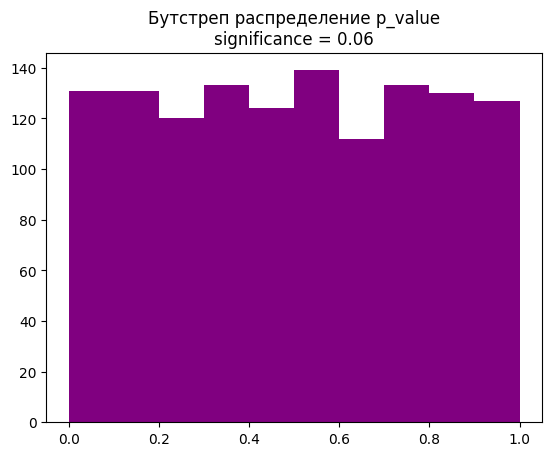

In [ ]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value\nsignificance = {np.round(np.mean(significance_list), 2)}")

Давайте еще проверим критерием Колмогорова-Смирнова (о том, что получившееся распределение p_values есть равномерное распределение). Здесь нужно держать в уме, что критерий не очень мощный (помним, что мощный от 80% случаев найденных различий)

In [ ]:
import scipy.stats

stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
  print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
  print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.9625983343072511 - p_values равномерное распределение


## Валидируем мощность

Будем добавлять эффект в виде умножения значений в группе B на (1 + multiplier)

In [ ]:
def count_multiplier(effect, mean):
    """mean * k = mean + effect
    k = effect / mean + 1
    k = 1 + multiplier
    multiplier = effect / mean"""

    return effect / mean

In [ ]:
N = 10
power_list = []
effect_list = [(week1['total_dur'].mean() / 100) * percent for percent in [1, 3, 5]]

for effect in effect_list:

    power = []
    for i in tqdm(range(N)):
        bits = get_hash_mask(week1, hash_col='user_id')

        for j in range(bits.shape[1]):

            sample_1 = shuffle(week1[bits[:, j] == 0]['total_dur'].values)
            sample_2 = shuffle(week1[bits[:, j] == 1]['total_dur'].values)

            multiplier = count_multiplier(effect, sample_2.mean())

            left_side, right_side = bootstrap_mean_diff_ci(
              sample_1,
              sample_2 * (1 + multiplier),
              iters=100,  # iters = 1000 для реальных данных
              return_distribution=False
            )

            power.append(not left_side <= 0 <= right_side)

    power_list.append(power)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def plot_power(effect_list, power_list, color='pink',
               title='', verbose=True):

    x = effect_list
    y = [np.array(power_list[index]).mean() for index in range(len(effect_list))]

    if verbose:
        for effect, power in zip(x, y):
            print(f"вероятность, что бутстрап критерий найдет отличие в {effect}% = "
                  f"{np.round(power, 2)}")

    fig, ax = plt.subplots(1,1)
    ax.plot(x, y, marker='o', color=color)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{effect}" for effect in effect_list])
    ax.grid(False)
    ax.set_ylim([0, 1.1])
    plt.title(title)


Нас интересует мощность >= 0.8

То есть это значит, что критерий находит различие там, где оно ЕСТЬ, в 80% случаях

вероятность, что бутстрап критерий найдет отличие в 1% = 0.26
вероятность, что бутстрап критерий найдет отличие в 3% = 0.96
вероятность, что бутстрап критерий найдет отличие в 5% = 1.0


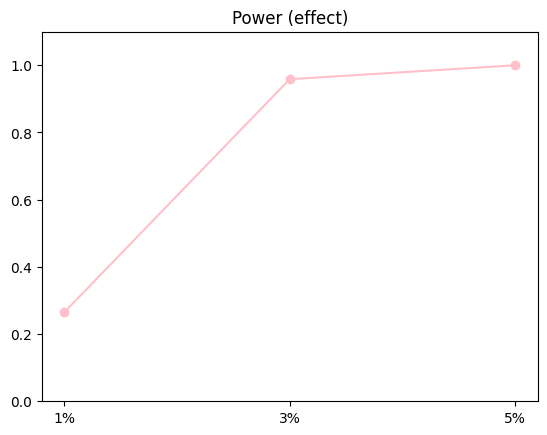

In [ ]:
plot_power([1, 3, 5], power_list, title='Power (effect)')

Видим, что мощность больше 0.8 достигается только если мы будем пытаться обнаружить разницу между группами в 5%. Это довольно большая разница, значит следующим шагом будут эксперименты с размером выборки

# Домашнее задание

## Размер выборки (N)

Выгрузите данные за 2 недели, выберите размер эффекта на ваш вкус и посчитайте мощность в зависимости от размера выборки

In [ ]:
# week2 =


In [ ]:
# N = 10
# power_list = []

# считаем мощность при разных размерах выборки
# for week in [week1, week2]:
